In [1]:
from benji_girgs import generation, plotting, utils
import networkit as nk
import networkx as nx
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
g, edges, weights, pts = generation.generate_GIRG_nk(1000, 3, 2.5, 2.0)

/cluster/home/bdayan/girgs/benji_src/benji_girgs/generation.py:114: RuntimeWarning: divide by zero encountered in divide
  p_uv = np.divide(outer, dists**d)


In [3]:
n=1000
d=2
tau=2.5
alphas = np.arange(1.1, 10.0, 0.4)
outs = []

for alpha in tqdm(alphas):
    for _ in range(3):
        g, edges, weights, pts, const, id2gnk = generation.cgirg_gen(n=n, d=d, tau=tau, alpha=alpha)
        percs = utils.get_perc_lower_common_nhbs(g, 2000)
        outs.append((alpha, np.median(percs)))


# plt.scatter([out[0] for out in outs], [out[1] for out in outs])

100%|██████████| 23/23 [00:34<00:00,  1.52s/it]


Text(0.5, 0, 'alpha')

Text(0, 0.5, 'median % common neighbours')

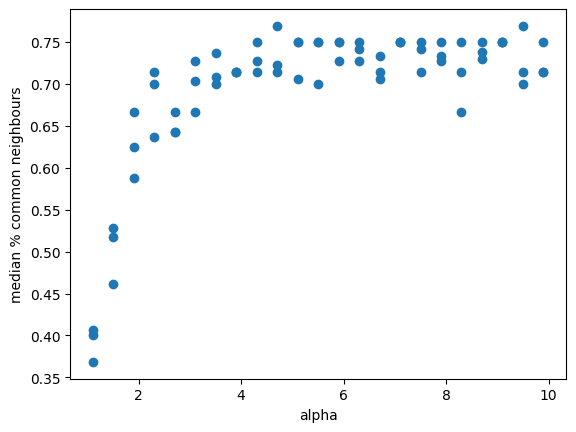

In [4]:
plt.scatter([out[0] for out in outs], [out[1] for out in outs])
plt.xlabel('alpha')
plt.ylabel('median % common neighbours')

Text(0.5, 0, 'd')

Text(0, 0.5, 'median % common neighbours')

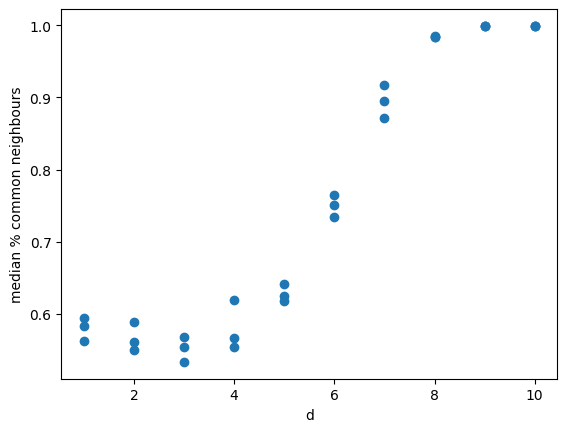

In [32]:
n=1000
ds = [1,2,3,4,5,6,7,8,9,10]
tau=2.5
alpha = 1.5
outs = []

for d in tqdm(ds):
    for _ in range(3):
        g, edges, weights, pts = generation.generate_GIRG_nk(n=n, d=d, tau=tau, alpha=alpha)
        percs = utils.get_perc_lower_common_nhbs(g, 2000)
        outs.append((d, np.median(percs)))


plt.scatter([out[0] for out in outs], [out[1] for out in outs])
plt.xlabel('d')
plt.ylabel('median % common neighbours')

In [30]:
outs2

[(1, 0.5945945945945946),
 (1, 0.5833333333333334),
 (1, 0.5625),
 (2, 0.5882352941176471),
 (2, 0.55),
 (2, 0.5609756097560976),
 (3, 0.5548862115127176),
 (3, 0.5335585585585585),
 (3, 0.5687597809076682),
 (4, 0.5671665731012911),
 (4, 0.55463885959242),
 (4, 0.6194029850746269),
 (5, 0.6414862914862915),
 (5, 0.6244343891402715),
 (5, 0.6182795698924731),
 (6, 0.751067618891857),
 (6, 0.7346999161023551),
 (6, 0.7642870101596517),
 (7, 0.8949212770957313),
 (7, 0.8716320525395539),
 (7, 0.917765156602772),
 (8, 0.9833869504481617),
 (8, 0.984530311188602),
 (8, 0.9838585107273906),
 (9, 0.9989594172736732),
 (9, 0.9989754098360656),
 (9, 0.9989743589743589),
 (10, 0.998998998998999),
 (10, 0.998998998998999),
 (10, 0.998998998998999)]

In [13]:
g, edges, weights, pts = generation.cgirg_gen(n=n, d=d, tau=tau, alpha=alpha)
nk.overview(g)

Network Properties:
nodes, edges			1000, 5526
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.011063
clustering coefficient		0.692514
min/max/avg degree		1, 210, 11.052000
degree assortativity		0.219826
number of connected components	1
size of largest component	1000 (100.00 %)


In [21]:
edges = list(g.iterEdges())

In [23]:
edges[0:10]

[(0, 1),
 (0, 270),
 (0, 133),
 (0, 388),
 (0, 135),
 (0, 132),
 (0, 251),
 (0, 65),
 (0, 129),
 (0, 235)]

In [24]:
dijkstra = nk.distance.Dijkstra(g, 0, True, True, 1)
dijkstra.run()

In [27]:
dijkstra.distance(1)
dijkstra.distance(2)

1.0

2.0

In [34]:
dijkstra.getPath(2)

[0, 133, 2]

In [35]:
g.removeEdge(0, 1)

In [44]:
biBFS = nk.distance.BidirectionalBFS(g, 0, 1, True)

In [46]:
biBFS.run()

In [38]:
biBFS.getPath()

[65]

In [40]:
biBFS.getDistance()

2.0

In [50]:
source, target = edges[1000]
source, target

(56, 456)

In [51]:
g.removeEdge(source, target)
biBFS = nk.distance.BidirectionalBFS(g, source, target, True)
biBFS.run()

In [52]:
biBFS.getPath()

[659]

In [55]:
preds = biBFS.getPredecessors()

In [64]:
preds = np.array(preds)


In [65]:
np.sum(preds==0)

979

In [68]:
np.unique(preds)

array([  0,  56, 659])

In [70]:
np.argwhere(preds==56).reshape(-1)

array([  1,  55,  56, 132, 134, 135, 161, 163, 165, 250, 277, 455, 653,
       659, 660, 661, 662, 718])

In [6]:
n=1000
d=2
tau=2.5
alpha=2.0
from girg_sampling import girgs

def cgirg_gen(n, d, tau, alpha, desireAvgDegree=None):
    """Generate a GIRG with C-library"""
    weights = girgs.generateWeights(n, tau)
    if desireAvgDegree is not None:
        weights = list(np.array(weights) * girgs.scaleWeights(weights, desireAvgDegree, d, alpha))
    pts = girgs.generatePositions(n, d)
    edges = girgs.generateEdges(weights, pts, alpha)
    # Make graph from edge list (not adjacency matrix)
    gnx = nx.from_edgelist(edges)
    gnk = nk.nxadapter.nx2nk(gnx)
    id2gnk = dict((gnx_id, gnk_id) for (gnx_id, gnk_id) in zip(gnx.nodes(), range(gnx.number_of_nodes())))

    return gnk, edges, weights, pts, id2gnk


In [34]:
n=5000
d=2
tau=2.5
alpha=1.01


for _ in range(3):
    g, edges, weights, pts, id2gnk = cgirg_gen(n=n, d=d, tau=tau, alpha=alpha)
    edges = list(g.iterEdges())
    outs = []
    for _ in range(40000):
        s, t = edges[np.random.choice(len(edges))]
        _ = g.removeEdge(s, t)
        biBFS = nk.distance.BidirectionalBFS(g, s, t, True)
        _ = biBFS.run()
    #     print(int(biBFS.getDistance())
        _ = g.addEdge(s, t)
        outs.append((s, biBFS.getPath(), t))

    lengths = [len(x[1]) for x in outs]
    np.unique(lengths, return_counts=True)


(array([1, 2]), array([38801,  1199]))

(array([1, 2]), array([39561,   439]))

(array([1, 2]), array([38212,  1788]))

In [33]:
n=5000
d=2
tau=2.5
alpha=1.5


for _ in range(3):
    g, edges, weights, pts, id2gnk = cgirg_gen(n=n, d=d, tau=tau, alpha=alpha)
    edges = list(g.iterEdges())
    outs = []
    for _ in range(40000):
        s, t = edges[np.random.choice(len(edges))]
        _ = g.removeEdge(s, t)
        biBFS = nk.distance.BidirectionalBFS(g, s, t, True)
        _ = biBFS.run()
    #     print(int(biBFS.getDistance())
        _ = g.addEdge(s, t)
        outs.append((s, biBFS.getPath(), t))

    lengths = [len(x[1]) for x in outs]
    np.unique(lengths, return_counts=True)


(array([1, 2, 3]), array([39212,   787,     1]))

(array([0, 1, 2]), array([    2, 39001,   997]))

(array([1, 2]), array([39356,   644]))

In [35]:
n=5000
d=2
tau=2.5
alpha=1.5


for _ in range(3):
    g, edges, weights, pts, id2gnk = cgirg_gen(n=n, d=d, tau=tau, alpha=alpha)
    edges = list(g.iterEdges())
    outs = []
    for _ in range(40000):
        s, t = edges[np.random.choice(len(edges))]
        _ = g.removeEdge(s, t)
        biBFS = nk.distance.BidirectionalBFS(g, s, t, True)
        _ = biBFS.run()
        _ = g.addEdge(s, t)
        outs.append((s, biBFS.getPath(), t))

    lengths = [len(x[1]) for x in outs]
    np.unique(lengths, return_counts=True)


(array([1, 2]), array([39593,   407]))

(array([1, 2, 3]), array([39272,   727,     1]))

(array([1, 2, 3]), array([38939,  1058,     3]))

In [52]:
n=5000
d=2
tau=2.5
alpha=1.5


for _ in range(3):
    g, edges, weights, pts, id2gnk = cgirg_gen(n=n, d=d, tau=tau, alpha=alpha)
    degrees = np.array(nk.centrality.DegreeCentrality(g).run().scores()).astype(np.int64)
    edges = list(g.iterEdges())
    outs = []
    low, up = np.quantile(degrees, q=[0.2, 0.8]).astype(np.int64)
    for _ in range(40000 * 12):
        s, t = edges[np.random.choice(len(edges))]
        degs = [degrees[s], degrees[t]]
        degs.sort()
        if degs[0] > low or degs[1] < up:
            continue
        _ = g.removeEdge(s, t)
        biBFS = nk.distance.BidirectionalBFS(g, s, t, True)
        _ = biBFS.run()
        _ = g.addEdge(s, t)
        outs.append((s, biBFS.getPath(), t))

    lengths = [len(x[1]) for x in outs]
    np.unique(lengths, return_counts=True)


(array([1, 2]), array([39972,   974]))

(array([1, 2]), array([41594,  1349]))

(array([1, 2]), array([41166,  1803]))

In [78]:
n=40000
d=2
tau=2.5
alpha=1.5


for _ in range(3):
    g, edges, weights, pts, id2gnk = cgirg_gen(n=n, d=d, tau=tau, alpha=alpha)
    degrees = np.array(nk.centrality.DegreeCentrality(g).run().scores()).astype(np.int64)
    edges = list(g.iterEdges())
    outs = []
    low, up = np.quantile(degrees, q=[0.2, 0.8]).astype(np.int64)
    for _ in range(40000 * 12):
        s, t = edges[np.random.choice(len(edges))]
        degs = [degrees[s], degrees[t]]
        degs.sort()
        if degs[0] > low or degs[1] < up:
            continue
        _ = g.removeEdge(s, t)
        biBFS = nk.distance.BidirectionalBFS(g, s, t, True)
        _ = biBFS.run()
        _ = g.addEdge(s, t)
        outs.append((s, biBFS.getPath(), t))

    lengths = [len(x[1]) for x in outs]
    np.unique(lengths, return_counts=True)


(array([1, 2, 3]), array([40016,  1205,     2]))

(array([1, 2]), array([39622,  1085]))

(array([1, 2, 3]), array([36288,  1776,    11]))

In [90]:
n=10000
d=3
tau=2.4
alpha=1.5

g, edges, weights, pts, id2gnk = cgirg_gen(n=n, d=d, tau=tau, alpha=alpha)

outs = []
for _ in range(10):
    v = np.random.choice(g.numberOfNodes())
    bfs = nk.distance.BFS(g, source=v, storePaths=True, storeNodesSortedByDistance=True)
    bfs.run()
    dists = bfs.getDistances()
    outs.append(np.unique(dists, return_counts=True)[1])

In [91]:
outs

[array([   1,   21, 7658, 2320]),
 array([   1,  126, 9228,  645]),
 array([   1,   77, 8575, 1347]),
 array([   1,   24, 4237, 5738]),
 array([   1,   33, 2861, 7105]),
 array([   1,   35, 5402, 4562]),
 array([   1,   72, 8743, 1184]),
 array([   1,   27, 8062, 1910]),
 array([   1,   91, 9087,  821]),
 array([   1,   23, 7761, 2215])]

In [92]:
g.degree(v)

23

In [93]:
gnk2id = {v:k for k, v in id2gnk.items()}

In [97]:
w = weights[gnk2id[v]]
w
r = w**(1/d)
r
r**d

1.2376200838672948

1.0736493103334088

1.2376200838672948

In [98]:
degrees2 = np.array(nk.centrality.DegreeCentrality(g).run().scores()).astype(np.int64)
degrees = [0]*len(degrees2)
for i, x in enumerate(degrees2):
    degrees[gnk2id[i]] = x


Text(0.5, 0, 'weight')

Text(0, 0.5, 'degree')

Text(0.5, 1.0, '10000 nodes, tau 2.4, alpha 1.5, d 3')

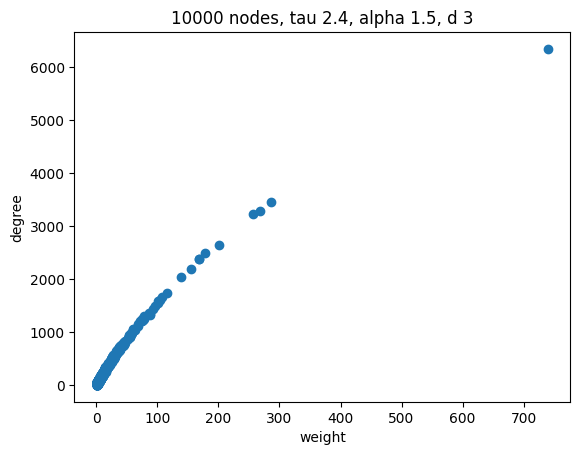

In [100]:
plt.scatter(weights, degrees)
plt.xlabel('weight')
plt.ylabel('degree')
plt.title('10000 nodes, tau 2.4, alpha 1.5, d 3')

Text(0.5, 0, 'weight')

Text(0, 0.5, 'degree')

Text(0.5, 1.0, '10000 nodes, tau 2.4, alpha 1.5, d 3')

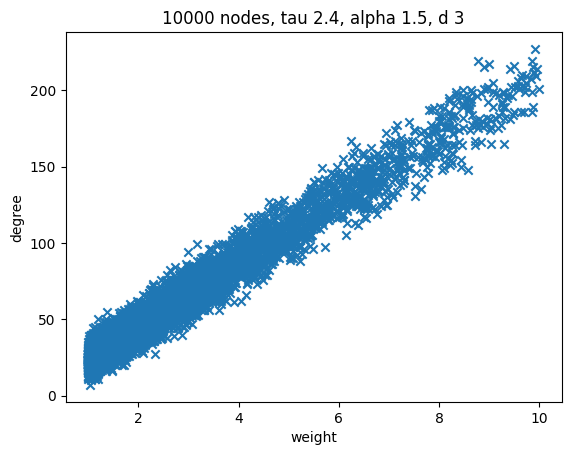

In [103]:
weights, degrees = np.array(weights), np.array(degrees)
plt.scatter(weights[weights < 10], degrees[weights < 10], marker='x')
plt.xlabel('weight')
plt.ylabel('degree')
plt.title('10000 nodes, tau 2.4, alpha 1.5, d 3')

In [41]:
np.quantile(weights, q=[0.25, 0.5, 0.75])

array([1.21491151, 1.59952941, 2.56272572])

In [48]:
degrees = np.array(nk.centrality.DegreeCentrality(g).run().scores()).astype(np.int64)
np.quantile(degrees, q=[0.2, 0.8]).astype(np.int64)

array([13, 34])

In [45]:
np.array(nk.centrality.DegreeCentrality(g).run().scores()).astype(np.int64)

array([ 106, 1566, 1247, ...,   10,    8,   12])

In [49]:
a = [1, 2, 3, 5, -1]
a.sort()
a

[-1, 1, 2, 3, 5]

In [93]:
edges[:5]

[(985, 726), (9, 726), (412, 726), (872, 726), (781, 726)]

In [94]:
g.hasEdge(985, 726)

False

In [95]:
edges2 = list(g.iterEdges())

In [96]:
edges2[:5]

[(0, 1), (0, 281), (0, 282), (0, 152), (0, 221)]

In [97]:
(0, 1) in edges

False

In [89]:
stuff = []
for _ in edges:
    stuff = stuff + list(_)

In [91]:
min(stuff)
max(stuff)

0

999